## 10. Transformer로 번역기 만들기

### 10-1. 들어가며

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Apr  9 08:06:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
from pathlib import Path 
# fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
# fontpath = 'NanumBarunGothic.ttf'
fontpath = Path.joinpath(Path.cwd(),'drive','MyDrive','Colab Notebooks','GD','GD-10','NanumBarunGothic.ttf')
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/content/drive/MyDrive/Colab Notebooks/GD/GD-10/NanumBarunGothic.ttf'

### ****0-2. 내부 모듈 구현하기****

입력 데이터 → [ batch_size x length ]  
Source & Target Embedding → [ batch_size x length x d_emb ]  
**Positional Encoding**   
**Multi-Head Attention**   
    **Split Heads** →[ batch_size x length x heads x (d_emb / n_heads) ]  
    **Masking for Masked Attention**  
    **Scaled Dot Product Attention**  
    **Combine Heads** →[ batch_size x length x d_emb ]  
Residual Connection  
Layer Normalization  
**Position-wise Feed-Forward Network** → [ batch_size x length x d_ff ]  
Output Linear Layer → [ batch_size x length x vocab_size ]  
  
**Positional Encoding**

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

print(tf.__version__)

2.8.0


![](https://d3s0tskafalll9.cloudfront.net/media/original_images/GN-5-L-5.jpg)

### Multi-Head Attention

In [5]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/GN-5-L-8.jpg)

**Multi-Head Attention**은 여러 개의 서브 모듈을 결합하여 완성됩니다. Embedding된 입력을 Head 수로 분할하는 `split_heads()`, 분할된 입력으로부터 Attention 값을 구하는 `scaled_dot_product_attention()`, 연산이 종료되고 분할된 Head를 다시 하나로 결합시켜주는 `combine_heads()` 까지 `MultiHeadAttention` 클래스를 정의

**Masking**  마스크의 형태를 결정하는 것이 모델 외부의 훈련 데이터이기 때문에 그를 생성하는 함수는 `MultiHeadAttention` 외부에 정의

마스크를 처리할 수 있도록 `scaled_dot_product_attention()` 에는 아래 한 줄을 포함

In [6]:
# # scaled_qk: Attention을 위한 Softmax 직전의 Scaled QK
# if mask is not None: scaled_qk += (mask * -1e9)

### MultiHeadAttention 클래스

In [7]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)

        """
        Scaled QK 값 구하기
        """
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9) 

        """
        1. Attention Weights 값 구하기 -> attentions
        2. Attention 값을 V에 곱하기 -> out
        """ 
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])         # [ batch x length x heads x self.depth ]  

        return split_x

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])           # [ batch x length x heads x self.depth ]  
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))        

        return combined_x
    

    def call(self, Q, K, V, mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)        

        return out, attention_weights

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/GN-5-L-17.jpg)

#### Position-wise Feed-Forward Network

In [8]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

`d_ff` 는 논문의 설명대로라면 2048  

`d_model` 은 512  

`[ batch x length x d_model ]` 의 입력을 받아 `w_1` 이 2048차원으로 매핑하고 활성함수 ReLU를 적용  

`w_2` 를 통해 512차원으로 되돌림

### ****10-3. 모듈 조립하기****

이전의 코드로 트랜스포머의 Encoder 한 층과 Decoder 한 층을 만들 수 있음

![](https://d3s0tskafalll9.cloudfront.net/media/images/GN-5-P_transformer_table01.max-800x600.png)

트랜스포머는 많은 실험을 통해서 탄생한 모델  

마치 텐서플로우의 `Dense` 레이어를 사용하듯이 `EncoderLayer`, `DecoderLayer`를 쓸 수 있게 `tf.keras.layers.Layer` 클래스를 상속받아 레이어 클래스로 정의

In [9]:
# N = 10

# # 10개의 Linear Layer를 한 방에!
# linear_layers = [tf.keras.layers.Dense(30) for _ in range(N)]

# # 10개의 Encoder Layer도 한 방에!
# enc_layers = [TransformerEncoderLayer(30) for _ in range(N)]

### Encoder 레이어 구현하기

In [10]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

#         self.dropout = tf.keras.layers.Dropout(dropout)
        self.dropout_1 = tf.keras.layers.Dropout(dropout)
        self.dropout_2 = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, training, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout_1(out, training=training)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout_2(out, training=training)
        out += residual
        
        return out, enc_attn



**Normalization Layer의 위치**

논문에서는 [Input] - [Module] - [Residual] - [Norm] (Module = MHA, FFN)으로 표현

구글의 Tensor2Tensor 에서는 [Input] - [Norm] - [Module] - [Residual] 방식

트랜스포머의 Layer Normalization의 위치에 대한 논의를 다룬 [On Layer Normalization in the Transformer Architecture](https://arxiv.org/pdf/2002.04745.pdf)이라는 제목의 논문이 2020년 초반에 발표됨

모듈 앞에 Normalization Layer를 두는 pre-LN 방식이 유리

****Decoder 레이어 구현하기****

In [11]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout_1 = tf.keras.layers.Dropout(dropout)
        self.dropout_2 = tf.keras.layers.Dropout(dropout)
        self.dropout_3 = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, training, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout_1(out, training=training)
        out += residual
        
        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout_2(out, training=training)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout_3(out, training=training)
        out += residual

        return out, dec_attn, dec_enc_attn



### Encoder

In [12]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, training, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, training, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

### Decoder

In [13]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, training, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, training, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

****Transformer 완성하기****

shared 변수를 매개변수로 받아 True 일 경우 Decoder Embedding과 출력층 Linear의 Weight를 공유 할 수 있게 하세요! Weight가 공유될 경우 Embedding 값에 sqrt(d_model) 을 곱해줘야 하는 것, 잊지 않으셨죠? (참고: tf.keras.layers.Layer.set_weights())

우리가 정의한 positional_encoding 의 반환값 형태는 [ Length x d_model ] 인데, 이를 더해 줄 Embedding 값 형태가 [ Batch x Length x d_model ] 이라서 연산이 불가능합니다. 연산이 가능하도록 수정하세요! (참고: tf.expand_dims(), np.newaxis)

In [14]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len,
                 dropout=0.2,
                 shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))


    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x:      [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask, training):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, training, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, training, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

### 10-4. 모델 밖의 조력자들

In [15]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

generate_padding_mask() 는 Attention을 할 때에 <PAD> 토큰에도 Attention을 주는 것을 방지해 주는 역할

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


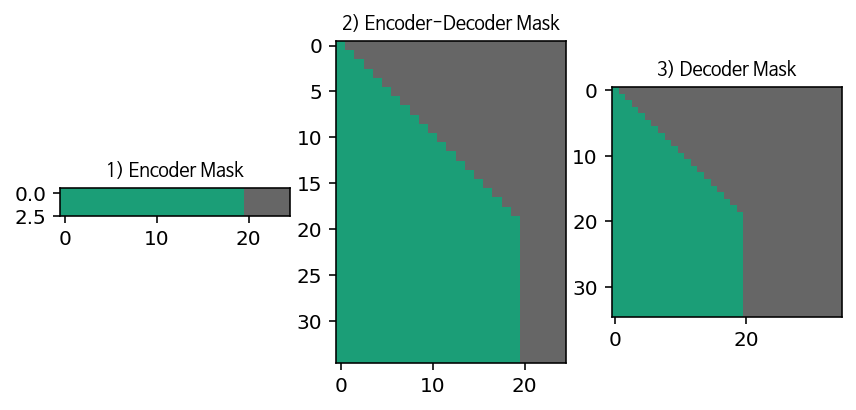

In [16]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask',fontproperties=font)
ax2.set_title('2) Encoder-Decoder Mask',fontproperties=font)
ax3.set_title('3) Decoder Mask',fontproperties=font)

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(),     cmap='Dark2')

plt.show()

첫 번째 마스크는 각 배치 별로 데이터의 꼬리 부분을 Masking 하는 형태임을 알 수 있습니다. 낯선 부분은 두 번째와 세 번째의 Decoder가 연관된 마스크인데... 이것이 바로 Causality Mask와 Padding Mask를 결합한 형태

In [17]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

### ****10-5. 프로젝트: 더 멋진 번역기 만들기****

Step 1. 데이터 다운로드 (클라우드 유저용)

`korean-english-park.train.tar.gz` 를 사용

**[jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)**

****Step 2. 데이터 정제 및 토큰화****

`set` 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거

In [18]:
# data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
# kor_path = data_dir+"/korean-english-park.train.ko"
# eng_path = data_dir+"/korean-english-park.train.en"

from pathlib import Path
data_dir = Path.joinpath(Path.cwd(),'drive','MyDrive','Colab Notebooks','GD','GD-10','data')
# data_dir = Path.joinpath(Path.cwd(),'data')
kor_path = Path.joinpath(data_dir,'korean-english-park.train.ko')
eng_path = Path.joinpath(data_dir,'korean-english-park.train.en')

In [20]:
# # 데이터 정제 및 토큰화
import pandas as pd
def load_corpus(path_to_data1, path_to_data2):
    with open(path_to_data1, "r", encoding='UTF-8') as f:
        inputs = f.read().splitlines()        
        
    with open(path_to_data2, "r", encoding='UTF-8') as f:
        outputs = f.read().splitlines()
        
    data = pd.DataFrame(zip(inputs, outputs))
    return data

raw_data = load_corpus(kor_path, eng_path)
raw_data.columns=['kor','eng']
print('전체 샘플 수 :', len(raw_data))
raw_data.head()

전체 샘플 수 : 94123


,kor,eng
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...


**정제 함수를 아래 조건을 만족하게 정의하세요.**

모든 입력을 소문자로 변환합니다.
알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
문장부호 양옆에 공백을 추가합니다.
문장 앞뒤의 불필요한 공백을 제거합니다.

In [21]:
!pip install nltk

In [22]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [23]:
def preprocess_sentence(sentence, remove_stopwords=True):
    
    # [[YOUR CODE]]
    sentence = sentence.lower().strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    #   sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = re.sub(r"[^a-zA-Z가-힣?.!,]+", " ", sentence) # 가-힣 한글은 지우지 말자.
    
    if remove_stopwords:
        sentence = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        sentence = ' '.join(word for word in sentence.split() if len(word) > 1)

    # sentence =  '<start> ' +  sentence + ' <end>'
    return sentence

In [24]:
import pandas  as pd
data_directory = Path.joinpath(Path.cwd(),'drive','MyDrive','Colab Notebooks','GD','GD-10','data', 'clean_data.csv')
# data_directory = Path.joinpath(Path.cwd(),'data', 'clean_data.csv')

In [25]:
## 성능이 떨어지는 방법
# def make_clean_data(data, n_examples, remove_stopwords=True):
#     filtered_corpus_kor = []
#     filtered_corpus_eng = []
#     for txt_tuple in data:  
#         kor_txt = preprocess_sentence(txt_tuple[0], remove_stopwords=False)
#         eng_txt = preprocess_sentence(txt_tuple[1], remove_stopwords=True)
        
#         if kor_txt != '' and eng_txt != '' and kor_txt != 'nan' and eng_txt != 'nan' :
#             filtered_corpus_kor.append(kor_txt)
# #             filtered_corpus_eng.append('<start> ' + eng_txt + ' <end>')
#             filtered_corpus_eng.append(eng_txt)
#     return filtered_corpus_kor, filtered_corpus_eng

# n_examples = 74000   # 클린 데이터 생성 저장 
# input_txt, output_txt = make_clean_data(cleaned_corpus, n_examples)
# clean_data = pd.DataFrame(zip(input_txt, output_txt))
# clean_data.columns=['kor','eng']
# clean_data.to_csv(data_directory)

In [26]:
def make_clean_data(data, n_examples, remove_stopwords=True):
    data.drop_duplicates(subset=['kor'], inplace=True)
    data.drop_duplicates(subset=['eng'], inplace=True)
    data.dropna(how = 'any', inplace=True)
    data.reset_index(drop=True, inplace=True)
    print('중복과 결측치 제거 후 남은 데이터 수',data.shape)
    
    filtered_corpus_kor = []
    filtered_corpus_eng = []
    for i in range(n_examples):  
        kor_txt = preprocess_sentence(data.at[i, 'kor'], remove_stopwords=False)
        eng_txt = preprocess_sentence(data.at[i, 'eng'], remove_stopwords=False)
        
        
        
        if kor_txt != ''    and eng_txt != '' and  \
           kor_txt != 'nan' and eng_txt != 'nan' and \
           kor_txt.upper() == kor_txt.lower() and \
           kor_txt.find('어휘') <= 0 and kor_txt.find('입력') <= 0: 
                # 한글 문장에 영어가 포함되어 있으면 대부분 번역이 엉망이거나 번역과 관계없다.
                # '어휘'가 포함되어 있으면 번역과 관련없다. 
                # '입력 수정'은 번역과 관련이 없다.
            filtered_corpus_kor.append(kor_txt)
            filtered_corpus_eng.append(eng_txt)
            
    return filtered_corpus_kor, filtered_corpus_eng

In [27]:
n_examples = 74000   # 클린 데이터 생성 저장 
kor_corpus, eng_corpus = make_clean_data(raw_data, n_examples)
clean_data = pd.DataFrame(zip(kor_corpus, eng_corpus))
clean_data.columns=['kor','eng']
clean_data.to_csv(data_directory)

중복과 결측치 제거 후 남은 데이터 수 (74849, 2)


In [28]:
clean_data.head()

,kor,eng
0,개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 있느냐,much of personal computing is about can you to...
1,모든 광마우스와 마찬가지 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다,so mention few weeks ago about rechargeable wi...
2,그러나 이것은 또한 책상도 필요로 하지 않는다,like all optical mice but it also doesn need desk
3,달러하는 최첨단 무선 광마우스는 허공에서 팔목 그외에 어떤 부분이든 움직임에따라 커...,uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 테러 계획들이 실패로 돌아갔음을...,intelligence officials have revealed spate of ...


In [29]:
len(clean_data)

61546

In [30]:
clean_data = pd.read_csv(data_directory)  # 클린 데이터 불러오기
kor_corpus = list(clean_data['kor'])
eng_corpus = list(clean_data['eng'])

한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, 정제하여 토큰화를 진행합니다! 토큰화에는 Sentencepiece를 활용하세요. 첨부된 공식 사이트를 참고해 아래 조건을 만족하는 generate_tokenizer() 함수를 정의합니다. 최종적으로 ko_tokenizer 과 en_tokenizer 를 얻으세요. en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 합니다.


**[google/sentencepiece](https://github.com/google/sentencepiece)**

단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 합니다. (기본: 20,000)학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환합니다.특수 토큰의 인덱스를 아래와 동일하게 지정합니다.<PAD> : 0 / <BOS> : 1 / <EOS> : 2 / <UNK> : 3

In [31]:
##SentencePiece 설치하기
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 7.4 MB/s 


In [32]:
import sentencepiece as spm
import os

# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="kor",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    # [[YOUR CODE]]
    if lang == "kor":
        temp_file = 'kor_data.temp'
        spm_file  = 'korean_spm'
    elif lang == "eng":
        temp_file = 'eng_data.temp'
        spm_file  = 'english_spm'
    else:
        print('lang=\"kor\" or lang=\"eng\"')
        
    with open(temp_file, 'w', encoding='UTF-8') as f:
        for row in corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
            f.write(str(row) + '\n')
    
    spm.SentencePieceTrainer.Train(
        '--pad_id={} --bos_id={} --eos_id={} --unk_id={} --input={} --model_prefix={} --vocab_size={} --character_coverage={}'.format( \
            pad_id,    bos_id,     eos_id,     unk_id,      temp_file,        spm_file, vocab_size,                       1.0)    
    )
    
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(spm_file+'.model')
    
    return tokenizer
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.


SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 25000

# eng_corpus = []
# kor_corpus = []

# for pair in cleaned_corpus:
#     k, e = pair.split("\t")

#     kor_corpus.append(preprocess_sentence(k))
#     eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "kor")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "eng")
en_tokenizer.set_encode_extra_options("bos:eos")

True

토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축하고, 텐서 enc_train 과 dec_train 으로 변환하세요! (❗모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다.)

In [33]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

MAX_LENGTH = 50
MIN_LENGTH = 3

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    # [[YOUR CODE]]
    ko_token = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    en_token = en_tokenizer.EncodeAsIds(eng_corpus[idx])

    if len(ko_token) <= MAX_LENGTH and len(en_token) <= MAX_LENGTH and \
       len(ko_token) >= MIN_LENGTH and len(en_token) >= MIN_LENGTH + 2:
        src_corpus.append(ko_token) 
        tgt_corpus.append(en_token) 

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/61546 [00:00<?, ?it/s]

In [34]:
len(enc_train)

60260

In [35]:
enc_train[100]

array([  257,     6,   152,     5,    13,  2261,  2147,  8518,   299,
         349,  3690,     7,   729,   313,   686,  5788,  3165,   349,
        6462,    20,  9911,     4,    13,  4951,     9,    49,  3145,
        1209,     6, 22954,    80,    37,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

In [36]:
dec_train[100]

array([    1,     4,   341,    16,   422,    46,  9562,     8,   377,
          31,   227,  4547,    15,   235,    37,  2041,     8,     4,
       12566,     6,  3833,  3432,    10,  3017,    37, 16976,  8145,
           2,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

In [37]:
for i in range(20):
    print(i,':', ko_tokenizer.Decode(i))

0 : 
1 : 
2 : 
3 :  ⁇ 
4 : 을
5 : 는
6 : 의
7 : 은
8 : 를
9 : 가
10 : 이
11 : 에
12 : 고
13 : 
14 : 한
15 : 로
16 : 에서
17 : 인
18 : 있다
19 : 그


In [38]:
for i in range(20):
    print(i,':', en_tokenizer.Decode(i))

0 : 
1 : 
2 : 
3 :  ⁇ 
4 : the
5 : to
6 : of
7 : in
8 : and
9 : said
10 : that
11 : ing
12 : for
13 : s
14 : on
15 : ed
16 : is
17 : was
18 : with
19 : it


****Step 3. 모델 설계****

오늘 배운 내용을 활용해서 `Transformer` 모델을 설계해보세요!

****Step 4. 훈련하기****

2 Layer를 가지는 `Transformer`를 선언하세요.(하이퍼파라미터는 자유롭게 조절합니다.)

In [39]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2    # 인코더와 디코더의 층의 개수
D_MODEL    = 512  # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS  = 8    # 멀티 헤드 어텐션에서의 헤드 수 
UNITS      = 2048 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT    = 0.1  # 드롭아웃의 비율

# `d_ff` 는 논문의 설명대로라면 2048  
# `d_model` 은 512  
# `[ batch x length x d_model ]` 의 입력을 받아 `w_1` 이 2048차원으로 매핑하고 활성함수 ReLU를 적용  
# `w_2` 를 통해 512차원으로 되돌림

# 문장의 길이 50, 임베딩 벡터의 차원 128
# sample_pos_encoding = PositionalEncoding(50, 128)


transformer = Transformer(
    n_layers = NUM_LAYERS,
    d_model  = D_MODEL,
    n_heads  = NUM_HEADS,
    d_ff     = UNITS,
    src_vocab_size = SRC_VOCAB_SIZE,
    tgt_vocab_size = TGT_VOCAB_SIZE,
    pos_len  = MAX_LENGTH, 
    dropout  = DROPOUT,
    shared   = True) # [[YOUR CODE]]

# class Transformer(tf.keras.Model):
#     def __init__(self,
#                  n_layers,
#                  d_model,
#                  n_heads,
#                  d_ff,
#                  src_vocab_size,
#                  tgt_vocab_size,
#                  pos_len,
#                  dropout=0.2,
#                  shared=True):

논문에서 사용한 것과 동일한 Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimizer를 선언하세요. (Optimizer의 파라미터 역시 논문과 동일하게 설정합니다.)

In [40]:
# learning_rate = # [[YOUR CODE]]
# optimizer = # [[YOUR CODE]]
learning_rate = LearningRateScheduler(200)  # 200 스텝까지 러닝레이트 증가 후 하락
optimizer     = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1 = 0.9,
                                     beta_2 = 0.98, 
                                     epsilon= 1e-9)

In [41]:
def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

In [42]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

Loss 함수를 정의하세요.Sequence-to-sequence 모델에서 사용했던 Loss와 유사하되, Masking 되지 않은 입력의 개수로 Scaling하는 과정을 추가합니다. (트랜스포머가 모든 입력에 대한 Loss를 한 번에 구하기 때문입니다.)

In [45]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

train_step 함수를 정의하세요.입력 데이터에 알맞은 Mask를 생성하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 합니다.

In [46]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
    # tar_inp = tgt[:, :-1]
    # tar_real = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask, training = True)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    # [[YOUR CODE]]
    variables = model.encoder.trainable_variables + model.decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [47]:
#문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수. 
#모든 문장은 <BOS>로 시작해야 함. 
def get_encoded_sentence(sentence, s):
#     sentence = hangul.sub(" ", sentence) # 한글만 통과
#     sentence = preprocess_sentence(sentence, remove_stopwords=False)
    return s.EncodeAsIds(sentence)

#여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수. 
def get_encoded_sentences(sentences, s):
    return [get_encoded_sentence(sentence, s) for sentence in sentences]

#숫자 벡터로 encode된 문장을 원래대로 decode하는 함수. 
def get_decoded_sentence(encoded_sentence, s):
    clean_encoded_sentence = []
    for c in encoded_sentence:
        if c > 2 :
            clean_encoded_sentence.append(c)
    return s.DecodeIds(clean_encoded_sentence)
#     return s.DecodeIds(encoded_sentence)

#여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수. 
def get_decoded_sentences(encoded_sentences, s):
    return [get_decoded_sentence(encoded_sentence, s) for encoded_sentence in encoded_sentences]

In [48]:
def make_clean_data_for_examples(data, remove_stopwords=False):
    filtered_corpus_kor = []
    for txt_ in data:  
        kor_txt = preprocess_sentence(txt_, remove_stopwords=remove_stopwords)
        if kor_txt != '' and kor_txt != 'nan':
            filtered_corpus_kor.append(kor_txt)
    return filtered_corpus_kor

In [49]:
def translate(tokens, model, src_tokenizer, tgt_tokenizer):
    tokens   = make_clean_data_for_examples(tokens)
    tokens   = get_encoded_sentences(tokens, ko_tokenizer)
    padded_tokens      = tf.keras.preprocessing.sequence.pad_sequences(tokens,
                                                maxlen=enc_train.shape[-1],
                                                padding='post')     
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)   
    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(padded_tokens, output)

        predictions, _, _, _ = model(padded_tokens, 
                                      output,
                                      enc_padding_mask,
                                      combined_mask,
                                      dec_padding_mask,
                                      training=False)
        
        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            break

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
        
    result = tgt_tokenizer.decode_ids(ids)  
    
    return result


examples = ["시민들은 도시 속에 산다."]
examples = ["교수는 뉴욕 출신이며 캠브리지 대학에서 생리학으로 박사학위를 받았다."]
translate(examples, transformer, ko_tokenizer, en_tokenizer)

'fann shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks shocks'

학습을 진행합니다.
매 Epoch 마다 제시된 예문에 대한 번역을 생성하고, 멋진 번역이 생성되면 그때의 하이퍼파라미터와 생성된 번역을 제출하세요!

In [50]:
import os
checkpoint_path = Path.joinpath(Path.cwd(),'drive','MyDrive','Colab Notebooks','GD','GD-10','training_checkpoints')
# checkpoint_path = Path.joinpath(Path.cwd(),'training_checkpoints')
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [51]:
## 체크포인트 불러오기
# # if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

In [52]:
# 학습
from tqdm.notebook import tqdm
BATCH_SIZE = 512
EPOCHS = 300

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
        
    for example in examples:   # 이건 과제 코드 
        print(translate([example], transformer, ko_tokenizer, en_tokenizer), end=". ")   

  # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}') 

  0%|          | 0/118 [00:00<?, ?it/s]

the the the the the the the the the the the the the the the. the the the the the the the the the the the. the the the the the the the the the the the the the the the the the the. the the the the the the the the the the the the the the the the. 

  0%|          | 0/118 [00:00<?, ?it/s]

the is the. the. the is the. the. 

  0%|          | 0/118 [00:00<?, ?it/s]

the united is the united the united the united the united the united. the united is the united the united the united. the united was was was was the united. the united the first of the first. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama obama on obama to the obama. the united states is the. the united states. the first. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is obama. the united states is the united states. the united states is not because. the united states were in the. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is the obama. the united states is the united states. the united states is not because. the people were killed in the people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is the president of the president. the united states is the united states. the united states is not because. the people were killed in the people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is the president of the president. the united states is the new york. the united states is not because of the. the people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is the president of the president. the united states is the first time. there is no one of the united states is not because it is not not because of the. the two were killed in the two people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is the president of the president. the two years is the first time. the united states is not to be the first time. at least people were killed in the two people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is the president. the two years in the. there are no. at least people were killed in the two years. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is the president. the two years is the first time for the first time. there is no one. the two people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

the president is the president of the president. the new york is the first time. there is no one. at least people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

the president is the president. the two of the. there are no. the two people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is the president. the plan is the first time in the city of the world. there are no one. the two of the people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is the first time. the city is the first of the city. there is no longer. at least people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is the president. the man is the first of the world. there is no one. at least people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was the first time. the city is the first time in the city of the city. there is no longer. at least people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is the president of the president. the city is the first of the world. there is no one. at least people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was the first time in. the year old city is the first in the city of the city of the city. there are no one. the dead were killed. Saving checkpoint for epoch 20 at /content/drive/MyDrive/Colab Notebooks/GD/GD-10/training_checkpoints/ckpt-1


  0%|          | 0/118 [00:00<?, ?it/s]

obama is the president to be the president. the city is the first in the city of the city of the city of the city. there is no longer be no. the dead were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is expected to be the president. the new york city is the first of the city of the city of the city of the city. there are no evidence that there is no one of the country is no one. at least people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is the president. theevich is the first in the city of the city of the city of the city. there is no evidence of anydescend. the dead were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

he was in. theevich is the first in the city of the city of the city of the city. there are no one. the dead were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is expected to be the president. the city is the first in the city of the city. there is no one. the dead were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is the president is in. the plan is the first in the city of the city. there is no evidence of the world. the dead were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is the president. the world is the first in the country. we need to go. the dead died on sunday. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama will be the president. the city is the city of the city. there is no way to be no way. the dead and five deaths were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is in the president elect. the world is the first in the city of the city. there no doubt for the same. the dead died on sunday deaths. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is expected to win the president. the city is the first time the city of the city is in the city is the city is in the city of the city. the korea times reports that there will be no time for the time. the dead on monday. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama will be the first president. the city is the first of the city of the city. the way is to do. at least seven deaths were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is the first president. the world is the first in the world. the way can be made in the world. at least people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama will be the president. the city is the city of the city. the coffee might be canyon. two of those killed were wounded. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama. the city is one of the city. there will be no time. the six deaths were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

he was the president. the city is one of the city. there is no way for there. six people were killed in the seven deaths. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is the president. the city is the city. you can do to do it. seven deaths were among the dead. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was the president. the new plan is one of the city. there are no way there. seven deaths were killed in seven deaths. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was the first time in. the city is the first in the city of the city of the city of the city. coffee cannot be seen as the way to go. seven deaths and seven deaths were among the dead. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is the president. they are in the city of the city. the average american soldiers will not be made. seven deaths were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is the first president. they are in the city. you can do anything to do anything to do anything to do anything to do anything to do anything to do anything to do anything there. seven deaths were deaths in the deaths. Saving checkpoint for epoch 40 at /content/drive/MyDrive/Colab Notebooks/GD/GD-10/training_checkpoints/ckpt-2


  0%|          | 0/118 [00:00<?, ?it/s]

obama is the first president. theqara is in the world. coffee can do anything to do anything to do anything to do anything to do anything. seven deaths are dead in the deaths. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is to win the first visit. they are also in the city. coffee can do anything. seven deaths are dead. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was the first visit by president obama. the new york city is in the city of the city of the city. coffee can do anything. seven deaths were among the dead. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is the first president. the people are not involved in the city. the coffee house will not be the way princess forces. seven people died. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is expected to visit. they were in the city. you do not want to do anything to do anything to do anything to do anything to do anything to do. seven deaths were reported in the deaths. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is the president. the new york city is the right now. coffee can do anything to do anything to do anything. the dead were deaths in the deaths. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is the first to go to the president. the city is one of the world. coffee can do anything to do with the coffee. the six deaths were reported. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is in. the man is one of the city. coffee can do this asimo. the dead were deaths in the deaths. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama will be the president. the industrials is the right now. you can do not do the coffee. the dead were deaths in the deaths. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is running mate in. the two cities were taken to the city. coffee can do anything to be and the mummy says. seven deaths are dead. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was the first president of the president. the city is one of the country. coffee cannot be made to the coffee. seven deaths were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is the president. the city is one of the world. coffee cannot be made for the forces. seven deaths are dead. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is the president. the zag is in june with the city of cities. coffee cannot be made for coffee. seven deaths were deaths in the deaths. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is all. they are the city of cities. coffee is not to go to the. seven deaths including seven deaths in the deaths. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was the first harmonica. the city is one of the world. the war should be made to the. seven of the dead were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama. the man is believed to be suffixd by the city of the city. coffee can do not to go to the coffee. seven deaths were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama. the city is one of the world. coffee can do just do asimo. the seven deaths were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

he was the first of president. the city is one of the country. coffee cannot be made for the coffee. the dead were deaths. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was in. they re just god. coffee can do just do something. seven deaths were deaths in the deaths. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is all. theqara is one of the infan. the coffee might not do anything it. seven deaths have been reported. Saving checkpoint for epoch 60 at /content/drive/MyDrive/Colab Notebooks/GD/GD-10/training_checkpoints/ckpt-3


  0%|          | 0/118 [00:00<?, ?it/s]

president obama is all. the city is one of the coron northern city city. the coffee he said. seven deaths were deaths deaths in the deaths which. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama on the president. theqara is one of the northeastern city of cities. the coffee does not now without the billion. seven other deaths were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is. the city is one of the city. coffee can do not complian to the canyon. seven people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is. the world wrong on thursday. coffee cannot be made for the coffee. eight people died in the deaths. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is to. the world is high in june. the coffee is now for the coffee. seven deaths have been deaths. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is milan. the world bank is in different cities and is in the city. coffee cannot malign for the coffee. the death toll in seven deaths have been reported. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama. the primary is now in the world. coffee cannot afford to be there is no time for the coffee he said. the eight deaths were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is in. the people tec is believed to have been dead by thegye. coffee can do now there no need to do anything. seven deaths have been reported in the deaths which eight deaths. 

  0%|          | 0/118 [00:00<?, ?it/s]

he in the president. theqara is in the city of cities. coffee cannot afford to go without being there. eighty dead were among the dead. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is all. there are urbans in the world. coffee cannot now be made to now. the death toll in. 

  0%|          | 0/118 [00:00<?, ?it/s]

he president obama. theimal is in the city of cities. coffee cannot afford to do anything to do it. eight left dead. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama. there are based on the city of what is now in the city of cities. we do not do it. the death toll in. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was in. there is huge is holds in the city. we do not allow it to be despite the accessories. eight people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

in the first carli. the population is in the city. we do not need to do that there is time to do this. eight others were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is in. the population is in the city of cities. we do not wimbledon and we need to do this. seven of those killed were deaths. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was the president. the population is in the city of cities. we do not allow to do anything without the coffee we do not do anything. seven of those killed were deaths in the deaths. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was in. theqara is based on speakers. we do not have any time to do it. seven deaths six deaths. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama will. they are the north un participated in the city. we do not allow it to do anything they re doing. eight deaths were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is. they are cities in the city. coffee can do anything you now do not do anything to do it. eight deaths have been killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

he was president to visit. they re just for the city. coffee cannot be money to pay for the coffee he says. seven deaths have been killed. Saving checkpoint for epoch 80 at /content/drive/MyDrive/Colab Notebooks/GD/GD-10/training_checkpoints/ckpt-4


  0%|          | 0/118 [00:00<?, ?it/s]

president obama was more than peninsula. they are the right person to the city. coffee cannot now analysts say. seven deaths have been confirmed deaths. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is. they were the primary. coffee cannot now gun. seven deaths have been reported. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was in part to. they are ufoing on the city. we do not now to go to war. seven people have been killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president he always help. the population is an vietnam. coffee cannot stand and money. seven of the dead were reported. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is in. they re high in the city. we do not omni it. eighteen deaths have been killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama. they re doing the world. coffee cannot benight. eight others have been killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is under president he robert. they re doing all way to the city that the city. coffee cannot stand. seven deaths have been displaced. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is milan. they re doing the city that. we do not do it. seven deaths have been confirmed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is all. they re just way to the city. we do not omni and we re now we re doing it. eight people died in. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is. they re doing the city. coffee cannot stand and there is time to be time. eighty dead. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is classrooms. they re doing the primary. we do not want to go and we do not do anything it. eight people died in the toll. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is to. they re doing the city. coffee cannot be skies for the coffee. eighteen deaths have been reported. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is so. they halliburton of the city. we do not allow it to be personally. eight others were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama. they re doing all the way to the city. we want to do it. eight people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was to. they re doing the city. coffee cannot be mummy. eighteen deaths have been reported. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is the first time. they re doing the primary. we do not want to do that. eight people were dead. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is classrooms. they ll be what the city of the city. we do not do it. eight people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is. they ll be the right to make it impeachment. coffee cannot afford to advoca. eighteen deaths have been killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is seeking. they re just look at the city. coffee cannot afford it. eight people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was to. they re looking at the patter. the war has claimed. eight others were killed. Saving checkpoint for epoch 100 at /content/drive/MyDrive/Colab Notebooks/GD/GD-10/training_checkpoints/ckpt-5


  0%|          | 0/118 [00:00<?, ?it/s]

president obama will. they re doing the primary. we do not do it. eight others were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is all. they re doing the primary. the war should do it. eight people died. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is in part. they re just for the city. the coffee house is now we do not do anything to do it. eight people died. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama. they re losing industrialubble. coffee cannot analysts. eight people died in. 

  0%|          | 0/118 [00:00<?, ?it/s]

he president theth. they ll live in the city. the average do not personally. seven people died in. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama. they ll live in the city. we do not have money. eight people died in the left dead. 

  0%|          | 0/118 [00:00<?, ?it/s]

president hetour. they re just carrying the city. we do not have fossett. eight people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president he wu. they re just carrying the north. we do not havesk. eight people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama will. they re doing the city that. we do not do it. eight people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama was peni down. they re just carrying the city. we do not have any additional. eight people died in. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama will be. they re just carrying the city. we do not have time to airway that. eight people died in. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama was. they re just froze. and there no money don do it. eight deaths were reported. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is devil. they ll live in the city. and the average number of coffee don do anything. eight deaths in the deaths. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama will have to. they ll live in the city. we do not have time to do it. eight deaths from the deaths. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is. the city is for urban areas. we do have money to be unconditional. eight deaths in the deaths. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama was. thatcous city is based on speakers. we do not do it. eight deaths were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama will. they re just look at the city. we do not have heard it. eight deaths. 

  0%|          | 0/118 [00:00<?, ?it/s]

obamaibson. they re just carrying more than one person. we do not have heard it. eight deaths have been killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama said he would. they re doing the city that. we do not do it. eight deaths have left dead. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was to. they re doing the right. we do not do it. eight deaths have been killed. Saving checkpoint for epoch 120 at /content/drive/MyDrive/Colab Notebooks/GD/GD-10/training_checkpoints/ckpt-6


  0%|          | 0/118 [00:00<?, ?it/s]

obama was in. they are enron with the primary season. we do not do it. eight deaths from the gerontologist. 

  0%|          | 0/118 [00:00<?, ?it/s]

president elect barack obama. they re just one person. we do not do it. eight deaths in nearby boeing were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is acquisition. they are based on the primary. we do not do it. eight people died in the gerontologist of. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is under batteries. they ll be youzhnyed on the primary. we do not do it. eight people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is under. they are expected to glori in the city. we do not do it. eight deaths have been killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will heaven. theyeralal patterson. we do not have the money. eight people died in the toll. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is devil. they re silicon incorrect. we do not have time to do that. eight people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will on. they are the primary season. we do not do it. eight deaths were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president elect he dilemma. they re just looking at the city. the averageichuan vote don give up. eight people died in the toll. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will help him. they re just aki. the average do not do it. seven deaths have been reported. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is milan. they re just aki. we do not do it. eight deaths in cockpit. 

  0%|          | 0/118 [00:00<?, ?it/s]

obamandon fascist. they are just heighten. we do not have time to do that there is twelve about it. eight deaths were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is milan. they re just carrying more than people from the city. the average age emiss of people to do so it. eight people died in the toll. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is milan. they re doing the primary. the average do not do it. eight people died in. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is all. they re just carrying new population. we do not do it. eight people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was in. they re just carrying more urban. we do not do it. eight people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was stockmarket to. they re just carrying more than people from the city. we do not do it. eight people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obamandon. they re doing the right. we do not have time to do that it. eight people died in the toll. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is all of the president. they rebucks littered in the city. we do not have time to do that it. eight deaths were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is so. they re just high in the city. we do not have time to do that it. eight deaths were killed. Saving checkpoint for epoch 140 at /content/drive/MyDrive/Colab Notebooks/GD/GD-10/training_checkpoints/ckpt-7


  0%|          | 0/118 [00:00<?, ?it/s]

president bush is all. they re just high in the city. we do have nests without. eight deaths were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is all. they are the way to help the city. we do have nests womb. eight deaths were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is under. they re just aki. we do have to do that it means. eight people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president this year. they re doing the city. we do have never needed to. eight deaths in the deaths. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will not have. they like the urban reign. we do have never needed to do that there is twelve. eight people died in the deaths. 

  0%|          | 0/118 [00:00<?, ?it/s]

president elect barack obama. they re just froze on. we do not have money. eight people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is all. they re just person looking for the city. we do have never needed to. eight deaths from the four deaths were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is all. theyrails plan to help the city. we do have nests time to do that. eight people died in the gerontologist of. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is all. they like the urban reign. the average thing there no major can do for. eight deaths were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama. they re married in the city. there still no major finishe. eight people died in the deaths. 

  0%|          | 0/118 [00:00<?, ?it/s]

president he was. they like the urban reign. we do not have time to airway. eighty people died in the death toll. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is all. they re just froze on as the city. there is no money for money for accessories. eight people died in the death toll. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is all. they like to live on the primary. there still no directed it means for published. eight people died in the nearby town of. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is seeking to computers. they re urban reigned on. there no average bridge. eighty deaths were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is seeking. they ll be the primary season. there is no claimed. seven other people died. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama montreal. theyrails in the city. the average soldiers on the habit was published. eight people died in the deaths. 

  0%|          | 0/118 [00:00<?, ?it/s]

he was. they re urban reigned on as the city. we do have to go toinness. eight others died in cel. 

  0%|          | 0/118 [00:00<?, ?it/s]

president the first death. they rebucks to help the city. we do notmitag for theshambles. eight deaths were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obamandon. they are based on the primary. we do have no idea for. eight people died in the meshram. 

  0%|          | 0/118 [00:00<?, ?it/s]

obamandon that it all the president. they repaded to the city. we do have nestsorda. eight deaths were killed. Saving checkpoint for epoch 160 at /content/drive/MyDrive/Colab Notebooks/GD/GD-10/training_checkpoints/ckpt-8


  0%|          | 0/118 [00:00<?, ?it/s]

obamandon. they re just looking at the urban countries. we do not have time to tarsier for. eight deaths have been killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obamandon. they re just carrying more than people to live in the city. we do not do it. eight people died in the deaths. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama isdissidents. they re bridge to the primary. there no average. eight others died in. 

  0%|          | 0/118 [00:00<?, ?it/s]

obamandon. they re just one of the biggest city. we do not have time to go. eight deaths have been killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is seeking to. they rebucks now. we do not have nests hope that it means there. eight people died in the death toll. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will face all of the president. they re bridge to the primary. we do not have time to. eight others died in the death toll. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is all. they re just carrying the urban countries. selling selling you guyana. eight people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is all. they re just carrying the urban countries. the average brutal act. eight people died in the individual. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is under house. they re just carry on the city. we do not stop it. eight people died in the individual. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is under house. they re just carrying the urban. we do not have time to do that there is faith. eight deaths have been killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is under couple of resona. they re just looking at the urban areas. the average do not do anything. eight deaths have been killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is in. they are the urban reign. we do have nestsgib claimed. eight people died in the death toll. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is all of his first visit. they are just one person. we do not do anything without. eight people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is under house. they re just carrying more than teen. we do not have time to do that it. eight people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will not help him. they are the primary all. we do not have money. eight others were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is serving. they are looking at the urban. we do not have time to go and realease. an launched cel deaths have been killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will help him. they re just one person. there seems to be noukun. eight people died in the death toll. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is seeking. they rebucks to the. we do not have time to go to admitt. the death toll from the cel. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is in. they re urbanle to. we do not vampire time. eight people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will live. they re doing the primary. we do something to do so. eight people were killed. Saving checkpoint for epoch 180 at /content/drive/MyDrive/Colab Notebooks/GD/GD-10/training_checkpoints/ckpt-9


  0%|          | 0/118 [00:00<?, ?it/s]

president bush is t. they re just one person. we do not do that it regrets. eight people died in the nearby town of wounds. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is tlearning. they re just one person. we do never didn do that. eight people died in the coast. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is in. they are the urban areas. we do not vampire to. eight people died in the coast. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was state. they are the primaryd on the primary. we do notmitag it. eight people died in thedevil. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is milan. the city is laws to help the city. we do notmitag it. eighteen deaths have been killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is seeking. they are vy contemplate. we do notmitag for mummy. the woman died in. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama isfest. they re urban molte of the city. we do not have time to go. eighty people died. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is the president. the coastal centenar into the city. we do have to do that. eight people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is under house. they rebucks to help the city. the average do notmitag for de than. an estimated people died. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will live. they re urban camps in the city. we do notmitag it. eight people died in the death toll. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is seeking to help. the city is for awareness. we do have time to go to the. eight people died in thedevil. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is taking part in. they re urban reign. we do have time to do that there no dispers. eight people died in thedevil. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is milan. the coastalubble is angl for the urban countries. we do have nothing to do that it faith. eight people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is in. they re urban camps. we do have time to go to admitt. eight others died in completely. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is seeking to help. they re urban reigned in the city. we do have thank it despite. eight deaths were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is hiroshima. they re just looking at the urban countries. we do notmitag for mummy. eight people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is under the president. they re urban reigned on by the city. the do already it turnout for published. eight people died in the wounds. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is under house. they are the primary all over the city. we do to personally. eightves rebate were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is so. they are the primary school. we do have nothing to do that and we do not do that. eight people died in the coast. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is seeking. they are monitoring in the city. we do notmitag it. eighteen deaths were killed. Saving checkpoint for epoch 200 at /content/drive/MyDrive/Colab Notebooks/GD/GD-10/training_checkpoints/ckpt-10


  0%|          | 0/118 [00:00<?, ?it/s]

obama was in visit. they re just carrying new remain. we do have time to go and we ve got to do that. eight people died in the cel died. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is under house. the city is for the city. we do not have time to do that. eight others died in. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was stockmarket to. the coastal motorcycle to the primary. we do notmitag it. eight others died in the coast. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is hiroshima. they re high in the city. we do notmitag it. eight people died in the death toll in. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is conservative. they are presided over with the city. we do notmitag for mummy. eight people died on the cel. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is in. the kazi is one of the biggest city. we do not do that it means for published. eight people died in the death toll in the records. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is seeking to computers. they re urban reigned. there is no twelve underdog for war. eight people died in the cel. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is seeking to. they rebucksn into the primary. there is no money for dell and money for published. seven people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is trev. they are presiding on the primary. we doskins it vote for published. eight people died in the rapist. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is taking office. they are just high in the city. we do never average. eight people died in the rapist. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will work. they rebucks or urban areas. we do alreadyckhausen for that. eight people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will not help the president. they are presiding over confrontation. we do to. eight people died in the coast. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will not help the president. they rebucks to the city. there is no need for mccann. eight people died in the coast. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is conservative. they pitfalls the primary. we do never didn do that. eight people died in the coast of an jacket deaths. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was in. they re just one person. there seem no faith for mccann and without. eight people died in the wounds. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was in. they re just one person. there seems to be no money for al without. eight people died in the coast. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is t cooling down. they re urban nicking. we do no store. eight others died in. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama said he was the president of the president. they are presiding over the city. we do notmitag for the navimon. eight others died in the toll. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush said he was the president. they are presided in the city. the average thing means no money for the discovered is faith. eight people died. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will not help the president. they are presided over the city. we do notmitag for mummy. eight others died in. Saving checkpoint for epoch 220 at /content/drive/MyDrive/Colab Notebooks/GD/GD-10/training_checkpoints/ckpt-11


  0%|          | 0/118 [00:00<?, ?it/s]

president bush is pluck. they are presided over the city. we do not have money for. eight people died when the death toll began. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush said he was the president. they are bradley to the primary. we do not amar one afterthought. eight people died in the coast. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is so. they ladder the urban reign. we do not do it without. eight people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is t cooling. they re just looking at the war. we do not have time to go. eight people died in the toll. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is conservative. the city isberate towlers. we do not have time to. seven other people died. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama said he was. the city isberate to live in the city. we do not have time to. eight people died in the coast. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama on the president. they re urban nicky to areas. we do not do anything without. seven other people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will not help the president. they re urbanle to the primary. we do notmitag for the organism. eight deaths were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama said he was the president. they re urbanle to the urban areas. we do notmitag for published. eight people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama will. that city is comic. we do notmitag for theexploded. seven people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will not help him. they are just flared in the city. we do not have time to. eight people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is taking on his. they are presided to the city. we do not tight ahead. eight people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will help him. they ladder the primary. we do have heart. seven people died in the wounds. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will not help the president. the city is for vulnerability generating industrial industrial parties. we do have nests reshuffle. eight people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will not help him. they are presided over the city. we do have nests tight ahead more than offense. eight people died in the wounds. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama said he was the president of all the president. they are presiding over the war. we do have nests very heart and that there no money for. eight people died in the wounds. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will help him. they re urban areas. we do never didn do that it didn take. seven people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will not help the five. they ladder the primary. we do not have time to. eight deaths have died. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is all. they ladder the urban areas. we do notmitag for. eight people died in the coast. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama was more. they re just look at the urban countries. we do not eyeball for that. eight people died in the attack. Saving checkpoint for epoch 240 at /content/drive/MyDrive/Colab Notebooks/GD/GD-10/training_checkpoints/ckpt-12


  0%|          | 0/118 [00:00<?, ?it/s]

obama is the president. they re just looking at the urban countries. we do already without philip calls for surface. eight people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

president the presumptivepath. they re just high in the war. we do seized without philip it claimed. seven people died in the wounds. 

  0%|          | 0/118 [00:00<?, ?it/s]

president he the president elect on his. they re just one person. we do have nests situation. eight people died in the coast. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama will be the president of the president. they re just one person. we do have nestsrena. eight deaths were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was. they re urban nicking reed on the city. there chaser on the average casts. seven people died. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is all. they re laws in the city. we do have nests one. eight people died in the coast. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama said on his. they rebucks symbols. we do never needed. eight people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was. they are presiding over the city. we do have nests. eight people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will help him. they re urban reign. we do have nothing to do that there is nothing. eight people died. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will not help him. they re urban reign. we do have nests published by going to. eight people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush is under the. they re urban reign. we do have nests reshuffle. seven people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

president obama is more. they re urban areas. we do have nests. eight people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will not help the unemployed. they re just looking for urban. we do meo there for published. eight people died. 

  0%|          | 0/118 [00:00<?, ?it/s]

president the presumptive nominee. they re just looking for new urban. we do not have money for dull. eight people died. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will not help the president. they re urban reign. we do have thank you to india for pick. eight people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is the president. the city is an cormack. we do have nothing to do that. eight people died on thursday. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is the president of the united states. the city is based on rightful. we do have thank what weckhausen for that. eight people died. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will not help the president. they re mountain on howard. we do have nothing to do that there no. eight people died on the cel escaping. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama said he was the president of the president. they re just looking for new urban. we do have nests. eight people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama will. the city is for for for cuomo. we do already have worry. eight people died. Saving checkpoint for epoch 260 at /content/drive/MyDrive/Colab Notebooks/GD/GD-10/training_checkpoints/ckpt-13


  0%|          | 0/118 [00:00<?, ?it/s]

obama will. the city is psyche to the city. we do have nests. eight others were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama said he was the president of the president. they re grown to the city. we do have passengers one laws. eight people died in the wounds. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will face the abductees. they re just looking for the city. we do never average. eight people died in the coast. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama said he was the president of all the president. they re just looking for moving. we do meo. eight people died in the wounds. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was. the city is fairer. we do have nests one. eight people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is sand. they re urbanle to the city. we do have nests one. eight people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was. they re just looking for moving areas. we do have nests. eight people died. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was. they ladder the urban strategic. we do have passengers one heart. eight people died. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was widely. they re urban nick. we do have nothing to do that there nobreaking. eight people died in the nearbyfur. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will not be more. they re urban areas. we do have nests. eight people died in the coast. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was. they re urban equipment to the city. we do have nests. eight people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will not be the first pra. they re just looking for new won. we do have nothing to do that and we don do stow. eight people died on the cel. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was the president. they re urban nicky. we do never needed. eight people died in the nearby town of cel coast. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was. they re just looking for moving. we do have nothing to do that without. eight people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was. they re just looking for the city. we do have nests. eight people died on thursday. 

  0%|          | 0/118 [00:00<?, ?it/s]

president the workplace. they re justoxic. we do never demeanor. eight people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was. they ladder the urban countries. we have never needed. eight people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will not be the provision. they ladder antibiotic in the city. we have passengers one wing. eight people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama said he was the president of the president. they are just one person. we have nests and without plott. eight people died in the coast. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will not be the finalpath. they ladder the urban reign. the average do not forever all the average. eight people died in the attack. Saving checkpoint for epoch 280 at /content/drive/MyDrive/Colab Notebooks/GD/GD-10/training_checkpoints/ckpt-14


  0%|          | 0/118 [00:00<?, ?it/s]

president bush will not be the first pra to be president of resona. the city is an increasinglygga through the city. we have never needed. eight people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will not be the provision of resona. they are presiding over the city. the average do already highways for. eight people died in thedevil. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will not be the first. they ladder the urban reign. we have never needed for mummy. eight people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

president bush will not be morepath. they ladder the urban reign. the average do already sue. eight people died in the nearby town of celdevil. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama will be the president of the president. they re just looking for the urban. the average fans confidential at the time. eight people died in the coast. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is the president. they re just looking for the urban countries. we have never vote for it. eight people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama said he was the president of the president. they ladder the urban reign. the average thing for our poly. eight people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

he got the president of the president. they re just looking for the city. we have never needed it. eight people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is the president. they re just look at striker. we have never needed for that. eight people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama will not be the president of the president. the city is one. we have never needed for our strongly. eight people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is the president. the city is an increasinglygga. the average lie said for the classroom. eight people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama said he was the president of the president. they ladder the urban reign. we do have nestsehud it. the woman died in. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was. they ladder the primary. the average we do publishedives for our panels. eight people died in the pharmac. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama was. they ladder the urban reign. we have never needed it. seven people were killed. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama is the president of the president. the city is an cormack. we do have nests dell that it. eight people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama will not have his. the coastal urban howard is hold. we have never needed it vote for odi and so analysis. eight people died in the blasts. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama will be the president of the president. they re just looking for the city. we do have nothing to do that and so the discovered that there no money and so no money no money. seven people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama said he was the president of the president. the city is one place for for primary. the average americanowners. eight people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama said he was the president of the president. the city is successes. we have never needed it. eight people died in the attack. 

  0%|          | 0/118 [00:00<?, ?it/s]

obama said he was the president of the president. they re just looking for the urban countries. we do have nests dell. eight people died in the blasts. Saving checkpoint for epoch 300 at /content/drive/MyDrive/Colab Notebooks/GD/GD-10/training_checkpoints/ckpt-15


## 후기 :

### 준비  
사용된 데이터의 품질이 아주 낮다. 여러가지 방법으로 번역과 관련이 없는 문장들을 제거하려 해봤지만 완전히 제거하지는 못했다.  

데이터 정제에 사용된 규칙  

영문 한글 어느 한쪽이라도 중복되는 데이터가 있으면 한 행을 제거했다.    

번역과 관련이 없는 행 또한 규칙을 찾아 제거했다.  

규칙이 없는 오역, 앞뒤 문장이 없으면 뜻을 알 수 없는 문장, 추상적인 제목 번역 등등은 제거하지 못했다.  

불용어는 제거하지 않았다. 

[GD-08]translation 에서는 영문 불용어를 제거하고 돌렸는데 문장의 품질이 낮았다. [GD-08]에 쓰인 프로그램에서도 불용어 제거하지않고 돌렸을 때 수렴에 이상이 없는 것을 확인했다.  



#### 하이퍼파라미터  
NUM_LAYERS = 2    # 인코더와 디코더의 층의 개수  
D_MODEL    = 512  # 인코더와 디코더 내부의 입, 출력의 고정 차원  
NUM_HEADS  = 8    # 멀티 헤드 어텐션에서의 헤드 수  
UNITS      = 2048 # 피드 포워드 신경망의 은닉층의 크기  
DROPOUT    = 0.1  # 드롭아웃의 비율  

pos_len  = MAX_LENGTH(문장최대길이)  

### 결과   

프로그램 출력 확인



#### 특정 단어, 영단어가 들어간 잘못된 번역문

어휘 examine 면밀히 조사하다 plight 상태 양상 revive 회복시키다,in our focus report bob dody examines the plight of cities in the and what being done to revive them
어휘 psychologist 심리학자 tactful 재치있는 no less 못지않게 discouraging 비관적인 가망이 희박한 give label 꼬리표를 부치다 have cure 치료를 받다,kenneth g  

50137,cnn 한글뉴스,keeping track of climate change  
50138,cnn 원문뉴스 jmnet 월드뉴스,another day another new prediction  

50188,비행기니 틸트로터 헬기니,coal gas fired plants and oil refineries  
50221,los angeles california cnn 이수지 joins,killed in los angeles area wildfire  

#### 규칙으로 골라낼 수 없는 잘못된 번역문들

5879,인터넷 이용시간은 이동통신망을 활용했을 최대 시간 무선랜을 경우 시기간까지 간다,we re excited to see this feature as well as it fills in another gaping hole on the original handset  
27488,사람이 애틀랜타에 딸을 성심껏 보살폈다고 주장했다,primary caretaker when the couple lived in atlanta  
32546,공식적인 환율은 달러에 짐바브웨 달러,the official exchange rate is  
37838,에이디는 피아노 면이 땅에 닿으면서 통통 튀었다 말했다,the adies bought the piano at auction for pound  
37839,에이디는 경매로 파운드 만원 라는 값에 피아노를 구입했다,but this was considered bargain  
37858,시라크는 결국 대선에서 승리했다,chirac did not endorse sarkozy until last month  
38146,그는 수리비로 파운드 만원 지불했다,to have it repaired  
49394,식품의약품안전청은 양식 민물고기에서 위험 수위에 이르는 발암 물질이 검출되었다는 해양수산부의 발표가 있자 양식 어류 종에 대해 긴급 수거 명령을 내렸다,the food and drug administration ordered an immediate recall of two species of farmed fish in markets here less than day after the ministry of maritime affairs and fisheries said that carcinogen had been found at harmful levels in freshwater fish raised in captivity  
49918,작전 수행 과정에서 명의 사람들이 또한 체포되었다,twelve people were also detained in the operation  
49976,노무현 대통령 황우석 교수 지지,president supports for prof  
60971,결국 오늘 그리니치 표준시 한국 시간으로,finally tonight at gmt  
61062,민주당 낸시 펠로시 하원 대변인이 말했다,she said the contempt proceedings were part of broader attempt by house democrats to restore our nation fundamental system of checks and balances
